# Convert Multi-Camera TIFF Stacks to Volumetric OME-Zarr

This notebook converts IsoView TIFF stacks (converted from KLB) into volumetric OME-Zarr files.

## Structure
- Each timepoint directory (TM000000, TM000001, ...) contains:
  - 4 cameras × TIFF stacks (79 z-planes each)
  - XML metadata files (one per camera)
  - MAT files (minIntensity, configuration)

## Output
- One OME-Zarr volume per camera per timepoint
- Conforms to OME-NGFF v0.5 specification
- Metadata extracted from XML files

In [2]:
# Imports
from pathlib import Path
import numpy as np
import time
from datetime import datetime
import pandas as pd
from tqdm import tqdm
import xml.etree.ElementTree as ET
from typing import Dict, List, Tuple

In [3]:
import mbo_utilities as mbo
from mbo_utilities._writers import _write_zarr

## Configuration

In [67]:
# Paths
SOURCE_ROOT = Path(r"\\rbo-s1\S1_DATA\isoview\foconnell\io_corrected_test\tiff")
OUTPUT_ROOT = Path(r"\\rbo-s1\S1_DATA\isoview\foconnell\io_corrected_test\zarr_shard_compression_3")

# Processing options
COMPRESSION_LEVEL = 3  # GZip compression level (1-9, lower = faster)
USE_SHARDING = True     # Use Zarr v3 sharding for better performance
OVERWRITE = True        # Overwrite existing zarr files

# Pattern matching
CAMERA_PATTERN = "SPM00_TM*_CM*.tif"  # Match camera TIFF files
XML_PATTERN = "SPM00_TM*_CM*.xml"     # Match XML metadata files

# Create output directory
OUTPUT_ROOT.mkdir(parents=True, exist_ok=True)

print(f"Source: {SOURCE_ROOT}")
print(f"Output: {OUTPUT_ROOT}")
print(f"Source exists: {SOURCE_ROOT.exists()}")
print(f"Compression level: {COMPRESSION_LEVEL}")
print(f"Sharding: {USE_SHARDING}")

Source: \\rbo-s1\S1_DATA\isoview\foconnell\io_corrected_test\tiff
Output: \\rbo-s1\S1_DATA\isoview\foconnell\io_corrected_test\zarr_shard_compression_3
Source exists: True
Compression level: 3
Sharding: True


## Utility Functions

In [74]:
def parse_isoview_xml(xml_path: Path) -> Dict:
    """
    Parse IsoView XML metadata file from push_config format.

    Returns dict with keys:
    - z_step: z-step size in micrometers
    - dimensions: image dimensions
    - exposure_time: exposure time in ms
    - wavelength: illumination wavelength
    - camera_type: camera model
    - timestamp: acquisition timestamp
    """
    if not xml_path.exists():
        print(f"Warning: XML file not found: {xml_path}")
        return {}

    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()

        metadata = {}

        # Parse all <info> elements
        for info in root.findall('.//info'):
            key = list(info.attrib.keys())[0] if info.attrib else None
            value = info.get(key) if key else None

            if key and value:
                # Store specific fields we care about
                if key == 'z_step':
                    metadata['z_step'] = float(value)
                elif key == 'dimensions':
                    metadata['dimensions'] = value
                elif key == 'exposure_time':
                    metadata['exposure_time'] = float(value)
                elif key == 'wavelength':
                    metadata['wavelength'] = int(value)
                elif key == 'camera_type':
                    metadata['camera_type'] = value
                elif key == 'timestamp':
                    metadata['timestamp'] = value
                elif key == 'time_point':
                    metadata['time_point'] = int(value)
                elif key == 'planes':
                    metadata['planes'] = value
                elif key == 'detection_objective':
                    metadata['detection_objective'] = value

        # Format for mbo_utilities
        # Default pixel sizes (can be refined if known)
        metadata['pixel_resolution'] = (0.65, 0.65)  # Approximate for 20x objective

        # Use z_step if available
        if 'z_step' in metadata:
            metadata['dz'] = metadata['z_step']
        else:
            metadata['dz'] = 1.0  # Default

        # Frame rate (IsoView typically ~1-10 fps depending on config)
        metadata['frame_rate'] = 1.0  # Default, update if known

        return metadata

    except Exception as e:
        print(f"Error parsing XML {xml_path}: {e}")
        return {}


def get_camera_files(timepoint_dir: Path) -> List[Tuple[Path, Path]]:
    """
    Get all camera TIFF files and their corresponding XML files for a timepoint.

    IsoView file naming:
    - TIFF: SPM00_TM000000_CM00_CHN01.tif (camera 00, channel 01)
    - XML:  SPM00_TM000000_CHN01.xml (channel 01 - shared across cameras)

    Returns list of (tiff_path, xml_path) tuples.
    """
    tiff_files = sorted(timepoint_dir.glob(CAMERA_PATTERN))

    camera_pairs = []
    for tiff_path in tiff_files:
        # Extract channel from filename: SPM00_TM000000_CM00_CHN01.tif -> CHN01
        # Pattern: SPM00_TM{timepoint}_CM{camera}_CHN{channel}.tif
        parts = tiff_path.stem.split('_')

        # Find the CHN part
        channel = None
        for part in parts:
            if part.startswith('CHN'):
                channel = part
                break

        if channel:
            # Construct XML filename: SPM00_TM{timepoint}_CHN{channel}.xml
            timepoint = parts[1]  # TM000000
            xml_name = f"SPM00_{timepoint}_{channel}.xml"
            xml_path = timepoint_dir / xml_name

            camera_pairs.append((tiff_path, xml_path))
        else:
            print(f"Warning: Could not extract channel from {tiff_path.name}")
            # Fallback: try with .xml extension (will likely not exist)
            xml_path = tiff_path.with_suffix('.xml')
            camera_pairs.append((tiff_path, xml_path))

    return camera_pairs


def get_timepoint_dirs(source_root: Path) -> List[Path]:
    """
    Get all timepoint directories (TM000000, TM000001, ...).
    """
    dirs = sorted([d for d in source_root.iterdir() if d.is_dir() and d.name.startswith('TM')])
    return dirs


def get_output_path(camera_tiff_path: Path, output_root: Path) -> Path:
    """
    Generate output zarr path from input TIFF path.

    Example:
    Input:  .../TM000001/SPM00_TM000001_CM00_CHN01.tif
    Output: .../TM000001/SPM00_TM000001_CM00_CHN01.zarr
    """
    timepoint_name = camera_tiff_path.parent.name
    camera_name = camera_tiff_path.stem  # Remove .tif extension

    output_dir = output_root / timepoint_name
    output_dir.mkdir(parents=True, exist_ok=True)

    return output_dir / f"{camera_name}.zarr"


print("Utility functions loaded")

Utility functions loaded


## Scan Directory Structure

In [75]:
# Get all timepoint directories
timepoint_dirs = get_timepoint_dirs(SOURCE_ROOT)

print(f"Found {len(timepoint_dirs)} timepoint directories")
print(f"Range: {timepoint_dirs[0].name} to {timepoint_dirs[-1].name}")

# Check first timepoint structure
if timepoint_dirs:
    first_tp = timepoint_dirs[0]
    camera_files = get_camera_files(first_tp)
    print(f"\nFirst timepoint has {len(camera_files)} camera files")

    # Check for missing XML files
    missing_xml = [xml for _, xml in camera_files if not xml.exists()]
    if missing_xml:
        print(f"WARNING: {len(missing_xml)} XML files not found")
        for xml in missing_xml[:3]:
            print(f"  Missing: {xml.name}")

Found 201 timepoint directories
Range: TM000000 to TM000200

First timepoint has 4 camera files


## Test Metadata Parsing

In [76]:
# Test metadata parsing on first file
if timepoint_dirs:
    first_tp = timepoint_dirs[0]
    camera_files = get_camera_files(first_tp)

    if camera_files:
        test_tiff, test_xml = camera_files[0]
        print(f"Testing metadata extraction:")
        print(f"  TIFF: {test_tiff.name}")
        print(f"  XML:  {test_xml.name}")

        # Check if XML exists and parse
        if test_xml.exists():
            metadata = parse_isoview_xml(test_xml)

            if metadata:
                print(f"\nExtracted metadata:")
                # Show only the most important fields
                for key in ['z_step', 'wavelength', 'exposure_time', 'camera_type', 'dimensions']:
                    if key in metadata:
                        print(f"  {key}: {metadata[key]}")
            else:
                print("\nWARNING: Failed to parse XML metadata")
        else:
            print(f"\nERROR: XML file not found")
            print(f"Expected: {test_xml.name}")

            # List available XML files
            xml_files = list(test_xml.parent.glob("*.xml"))
            if xml_files:
                print(f"\nAvailable XML files in {test_xml.parent.name}:")
                for xf in xml_files:
                    print(f"  {xf.name}")

Testing metadata extraction:
  TIFF: SPM00_TM000000_CM00_CHN01.tif
  XML:  SPM00_TM000000_CHN01.xml

Extracted metadata:
  z_step: 5.13
  wavelength: 488
  exposure_time: 4.8
  camera_type: C11440-22C,C11440-22C
  dimensions: 2048x752x79,2048x752x79


## Test Single Conversion

Convert one camera file to verify the process works

In [77]:
import tifffile

if timepoint_dirs:
    # Test on first camera of first timepoint
    test_tp = timepoint_dirs[0]
    camera_files = get_camera_files(test_tp)

    if camera_files:
        test_tiff, test_xml = camera_files[0]
        test_output = get_output_path(test_tiff, OUTPUT_ROOT)

        print(f"Test conversion: {test_tiff.name}")

        # Read TIFF stack using tifffile directly
        stack = tifffile.imread(test_tiff)
        print(f"  Input shape: {stack.shape}, dtype: {stack.dtype}")

        # Parse metadata
        metadata = parse_isoview_xml(test_xml)

        # Stack should be (Z, Y, X) for a single volume
        if stack.ndim == 2:
            data = stack[np.newaxis, ...]
        elif stack.ndim == 3:
            data = stack
        else:
            print(f"  WARNING: Unexpected dimensions: {stack.ndim}")
            data = stack

        # Ensure all required metadata fields
        if 'num_frames' not in metadata:
            metadata['num_frames'] = data.shape[0]
        if 'dz' not in metadata:
            metadata['dz'] = 5.13
        if 'pixel_resolution' not in metadata:
            metadata['pixel_resolution'] = (0.65, 0.65)
        if 'frame_rate' not in metadata:
            metadata['frame_rate'] = 1.0

        # Clear any cached zarr writers
        if hasattr(_write_zarr, '_arrays'):
            _write_zarr._arrays.clear()
            _write_zarr._offsets.clear()
            _write_zarr._groups.clear()

        # Convert to OME-Zarr
        start_time = time.time()

        _write_zarr(
            test_output,
            data,
            metadata=metadata,
            ome=True,
            sharded=USE_SHARDING,
            level=COMPRESSION_LEVEL,
            overwrite=OVERWRITE
        )

        elapsed = time.time() - start_time

        # Calculate statistics
        input_size_mb = test_tiff.stat().st_size / (1024**2)
        output_size_mb = sum(f.stat().st_size for f in test_output.rglob('*') if f.is_file()) / (1024**2)
        compression_ratio = input_size_mb / output_size_mb if output_size_mb > 0 else 0
        throughput_mb_s = output_size_mb / elapsed if elapsed > 0 else 0

        print(f"  Conversion: {elapsed:.1f}s @ {throughput_mb_s:.1f} MB/s")
        print(f"  Size: {input_size_mb:.1f} MB → {output_size_mb:.1f} MB ({compression_ratio:.2f}x compression)")

        # Verify readback
        try:
            verified = mbo.imread(test_output)
            print(f"  Verified: {verified.shape}")
        except Exception as e:
            # Try with zarr directly
            try:
                import zarr
                z = zarr.open(test_output, mode='r')
                print(f"  Verified: {z.shape}")
            except Exception as e2:
                print(f"  WARNING: Verification failed: {e2}")

Test conversion: SPM00_TM000000_CM00_CHN01.tif
  Input shape: (79, 752, 2048), dtype: uint16
  Conversion: 2.2s @ 44.4 MB/s
  Size: 232.1 MB → 97.9 MB (2.37x compression)
  Verified: (79, 1, 752, 2048)


## Batch Conversion

Convert all camera files across all timepoints

In [78]:
OVERWRITE = False
OVERWRITE

False

In [79]:
# Statistics tracking
conversion_stats = []
failed_conversions = []

total_start_time = time.time()

print(f"Converting {len(timepoint_dirs)} timepoints...")
print("=" * 80)

for tp_idx, tp_dir in enumerate(timepoint_dirs, 1):
    # Get all camera files for this timepoint
    camera_files = get_camera_files(tp_dir)

    if not camera_files:
        print(f"[{tp_idx}/{len(timepoint_dirs)}] {tp_dir.name}: No camera files found")
        continue

    tp_start_time = time.time()
    tp_successes = 0
    tp_failures = 0

    for cam_idx, (tiff_path, xml_path) in enumerate(camera_files, 1):
        output_path = get_output_path(tiff_path, OUTPUT_ROOT)

        # Skip if already exists and not overwriting
        if output_path.exists() and not OVERWRITE:
            continue
        try:
            file_start_time = time.time()

            # Read TIFF using tifffile directly
            stack = tifffile.imread(tiff_path)

            # Ensure correct shape (Z, Y, X)
            if stack.ndim == 2:
                data = stack[np.newaxis, ...]
            elif stack.ndim == 3:
                data = stack
            else:
                data = stack

            # Parse metadata
            metadata = parse_isoview_xml(xml_path)

            # Ensure all required metadata fields
            if 'num_frames' not in metadata:
                metadata['num_frames'] = data.shape[0]
            if 'dz' not in metadata:
                print("No axial spacing found in metadata")
                metadata['dz'] = 5.13
            if 'pixel_resolution' not in metadata:
                print("No pixel resolution rate found in metadata")
                metadata['pixel_resolution'] = (0.65, 0.65)
            if 'frame_rate' not in metadata:
                print("No frame rate found in metadata")
                metadata['frame_rate'] = 1.0

            # Clear zarr cache
            if hasattr(_write_zarr, '_arrays'):
                _write_zarr._arrays.clear()
                _write_zarr._offsets.clear()
                _write_zarr._groups.clear()

            # Write OME-Zarr
            _write_zarr(
                output_path,
                data,
                metadata=metadata,
                ome=True,
                sharded=USE_SHARDING,
                level=COMPRESSION_LEVEL,
                overwrite=OVERWRITE
            )

            file_elapsed = time.time() - file_start_time

            # Calculate sizes
            input_size_mb = tiff_path.stat().st_size / (1024**2)
            output_size_mb = sum(f.stat().st_size for f in output_path.rglob('*') if f.is_file()) / (1024**2)
            compression_ratio = input_size_mb / output_size_mb if output_size_mb > 0 else 0
            throughput = output_size_mb / file_elapsed if file_elapsed > 0 else 0

            # Record stats
            conversion_stats.append({
                'timepoint': tp_dir.name,
                'camera_file': tiff_path.name,
                'input_size_mb': input_size_mb,
                'output_size_mb': output_size_mb,
                'compression_ratio': compression_ratio,
                'time_sec': file_elapsed,
                'throughput_mb_per_sec': throughput,
                'num_z_planes': data.shape[0],
                'success': True
            })

            tp_successes += 1

        except Exception as e:
            print(f"[{tp_idx}/{len(timepoint_dirs)}] {tp_dir.name}/{tiff_path.name}: ERROR - {e}")
            failed_conversions.append({
                'timepoint': tp_dir.name,
                'camera_file': tiff_path.name,
                'error': str(e)
            })
            tp_failures += 1
            continue

    tp_elapsed = time.time() - tp_start_time

    # Only print if there were issues or every 10 timepoints
    if tp_failures > 0 or tp_idx % 10 == 0 or tp_idx == len(timepoint_dirs):
        status = f"{tp_successes} ok" + (f", {tp_failures} failed" if tp_failures > 0 else "")
        print(f"[{tp_idx}/{len(timepoint_dirs)}] {tp_dir.name}: {status} ({tp_elapsed:.1f}s)")

total_elapsed = time.time() - total_start_time

print("\n" + "=" * 80)
print(f"Completed in {total_elapsed:.1f}s ({total_elapsed/60:.1f} min)")
print(f"  Successful: {len(conversion_stats)}")
if failed_conversions:
    print(f"  Failed: {len(failed_conversions)}")

Converting 201 timepoints...
[10/201] TM000009: 0 ok (0.0s)
[20/201] TM000019: 0 ok (0.0s)
[30/201] TM000029: 0 ok (0.0s)
[40/201] TM000039: 0 ok (0.0s)
[50/201] TM000049: 0 ok (0.0s)
[60/201] TM000059: 0 ok (0.0s)
[70/201] TM000069: 4 ok (11.3s)
[80/201] TM000079: 4 ok (11.4s)
[90/201] TM000089: 4 ok (11.1s)
[100/201] TM000099: 4 ok (11.6s)
[110/201] TM000109: 4 ok (11.4s)
[120/201] TM000119: 4 ok (11.6s)
[130/201] TM000129: 4 ok (11.5s)
[140/201] TM000139: 4 ok (11.3s)
[150/201] TM000149: 4 ok (11.2s)
[160/201] TM000159: 4 ok (11.3s)
[170/201] TM000169: 4 ok (11.2s)
[180/201] TM000179: 4 ok (11.5s)
[190/201] TM000189: 4 ok (11.1s)
[200/201] TM000199: 4 ok (11.3s)
[201/201] TM000200: 4 ok (11.1s)

Completed in 1559.8s (26.0 min)
  Successful: 546


## Conversion Statistics

In [80]:
if conversion_stats:
    df_stats = pd.DataFrame(conversion_stats)

    print("\nCONVERSION STATISTICS")
    print("=" * 80)

    # Overall statistics
    total_input_mb = df_stats['input_size_mb'].sum()
    total_output_mb = df_stats['output_size_mb'].sum()
    avg_compression = df_stats['compression_ratio'].mean()
    avg_throughput = df_stats['throughput_mb_per_sec'].mean()
    total_conversion_time = df_stats['time_sec'].sum()

    print(f"Total data processed: {total_input_mb/1024:.2f} GB → {total_output_mb/1024:.2f} GB")
    print(f"Average compression: {avg_compression:.2f}x")
    print(f"Average throughput: {avg_throughput:.1f} MB/s")
    print(f"Total conversion time: {total_conversion_time/60:.1f} min")

    # Save statistics
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    stats_file = OUTPUT_ROOT / f"conversion_stats_{timestamp}.csv"
    df_stats.to_csv(stats_file, index=False)
    print(f"\nStatistics saved: {stats_file.name}")

    # Save failed conversions if any
    if failed_conversions:
        df_failed = pd.DataFrame(failed_conversions)
        failed_file = OUTPUT_ROOT / f"failed_conversions_{timestamp}.csv"
        df_failed.to_csv(failed_file, index=False)
        print(f"Failed conversions logged: {failed_file.name}")
else:
    print("No conversions completed")


CONVERSION STATISTICS
Total data processed: 123.75 GB → 48.75 GB
Average compression: 2.54x
Average throughput: 32.4 MB/s
Total conversion time: 25.7 min

Statistics saved: conversion_stats_20251031_003218.csv


## Verification

Verify a few random converted files can be read back correctly

In [81]:
if conversion_stats and len(conversion_stats) > 0:
    # Verify a few random samples
    num_to_test = min(3, len(conversion_stats))
    test_samples = df_stats.sample(n=num_to_test)

    print("\nVERIFYING RANDOM SAMPLES")
    print("=" * 80)

    for idx, row in test_samples.iterrows():
        timepoint = row['timepoint']
        camera_file = row['camera_file']

        # Reconstruct zarr path
        zarr_name = Path(camera_file).stem + ".zarr"
        zarr_path = OUTPUT_ROOT / timepoint / zarr_name

        try:
            # Try mbo.imread first
            verified = mbo.imread(zarr_path)
            print(f"{zarr_path.parent.name}/{zarr_path.name}: OK ({verified.shape})")
        except Exception as e:
            # Fallback to zarr
            try:
                import zarr
                z = zarr.open(zarr_path, mode='r')
                print(f"{zarr_path.parent.name}/{zarr_path.name}: OK ({z.shape})")
            except Exception as e2:
                print(f"{zarr_path.parent.name}/{zarr_path.name}: ERROR - {e2}")


VERIFYING RANDOM SAMPLES
TM000092/SPM00_TM000092_CM02_CHN00.zarr: OK ((79, 1, 752, 2048))
TM000111/SPM00_TM000111_CM03_CHN00.zarr: OK ((79, 1, 752, 2048))
TM000107/SPM00_TM000107_CM00_CHN01.zarr: OK ((79, 1, 752, 2048))


## Summary

Final summary and next steps

In [82]:
print("\n" + "=" * 80)
print("SUMMARY")
print("=" * 80)

if conversion_stats:
    total_input_gb = df_stats['input_size_mb'].sum() / 1024
    total_output_gb = df_stats['output_size_mb'].sum() / 1024
    space_saved_gb = total_input_gb - total_output_gb
    space_saved_pct = (space_saved_gb / total_input_gb * 100) if total_input_gb > 0 else 0

    print(f"Processed {len(conversion_stats)} volumes in {total_elapsed/60:.1f} minutes")
    print(f"Data: {total_input_gb:.1f} GB → {total_output_gb:.1f} GB")
    print(f"Space saved: {space_saved_gb:.1f} GB ({space_saved_pct:.1f}%)")
    print(f"Average speed: {avg_throughput:.1f} MB/s")

    if failed_conversions:
        print(f"\nWARNING: {len(failed_conversions)} conversions failed (see logs)")

    print(f"\nOutput: {OUTPUT_ROOT}")
else:
    print("No files were converted")


SUMMARY
Processed 546 volumes in 26.0 minutes
Data: 123.7 GB → 48.7 GB
Space saved: 75.0 GB (60.6%)
Average speed: 32.4 MB/s

Output: \\rbo-s1\S1_DATA\isoview\foconnell\io_corrected_test\zarr_shard_compression_3


In [83]:
!uv pip install ome-zarr

Using Python 3.12.9 environment at: C:\Users\RBO\repos\millerbrainobservatory.github.io\.venv
Audited 1 package in 87ms


In [84]:
import ome_zarr

def consolidate_camera_volume(camera_id: str, zarr_paths: List[Path],
                              output_path: Path, axis_order: str = "TZYX",
                              compression_level: int = 1, pixel_size_um: Tuple[float, float] = (0.65, 0.65),
                              z_step_um: float = 5.13) -> Dict:
    """
    Consolidate multiple single-timepoint zarr files into one multi-timepoint volume using OME-Zarr.

    Parameters
    ----------
    camera_id: Camera identifier (e.g., 'SPM00_CM00_CHN01')
    zarr_paths: List of zarr file paths sorted by timepoint
    output_path: Output path for consolidated zarr
    axis_order: Either "TZYX" (time, z, y, x) or "ZTYX" (z, time, y, x)
    compression_level: GZip compression level (1-9)
    pixel_size_um: Pixel size in micrometers (Y, X)
    z_step_um: Z-step size in micrometers

    Returns:
        Dict with statistics
    """
    import zarr
    import shutil
    from ome_zarr.io import parse_url
    from ome_zarr.writer import write_image

    print(f"  Loading {len(zarr_paths)} timepoints...")

    volumes = []
    for idx, zpath in enumerate(zarr_paths):
        try:
            root = zarr.open_group(zpath, mode='r')
            arr = root['0'][:]

            # Remove singleton channel dimension if present
            if arr.ndim == 4 and arr.shape[1] == 1:
                arr = arr[:, 0, :, :]  # Now (Z, Y, X)

            volumes.append(arr)

            # Progress indicator
            if (idx + 1) % 50 == 0:
                print(f"    Loaded {idx + 1}/{len(zarr_paths)}...")

        except Exception as e:
            print(f"    ERROR loading {zpath.name}: {e}")
            return None

    if not volumes:
        print(f"    ERROR: No volumes loaded")
        return None

    print(f"  Stacking {len(volumes)} volumes...")

    # Stack along time dimension
    # volumes is list of (Z, Y, X) arrays
    stacked = np.stack(volumes, axis=0)  # Shape: (T, Z, Y, X)

    # Reorder axes if needed
    if axis_order == "ZTYX":
        # Transpose from (T, Z, Y, X) to (Z, T, Y, X)
        stacked = np.transpose(stacked, (1, 0, 2, 3))
        axes = "ztyx"
    elif axis_order == "TZYX":
        axes = "tzyx"
    else:
        raise ValueError(f"Invalid axis_order: {axis_order}. Must be 'TZYX' or 'ZTYX'")

    print(f"  Consolidated shape: {stacked.shape} ({axis_order})")
    print(f"  Writing to {output_path.name} using OME-Zarr...")

    start_time = time.time()

    # Remove existing if overwriting
    if output_path.exists() and CONSOLIDATE_OVERWRITE:
        shutil.rmtree(output_path)

    # Create Zarr v3 store using ome_zarr API
    store = parse_url(str(output_path), mode="w").store
    root = zarr.group(store=store)

    # Define chunk shape based on axis order
    if axis_order == "TZYX":
        # Chunk by single timepoint (T=1, Z=all or partial, Y=full, X=full)
        chunk_shape = (1, min(stacked.shape[1], 10), stacked.shape[2], stacked.shape[3])
    else:  # ZTYX
        # Chunk by single z-plane (Z=1, T=all or partial, Y=full, X=full)
        chunk_shape = (1, min(stacked.shape[1], 10), stacked.shape[2], stacked.shape[3])

    # Use ome_zarr.writer.write_image to create OME-NGFF compliant zarr
    # Don't provide coordinate_transformations - let write_image generate them automatically
    # based on the scaler parameter (defaults to 2x downsampling in Y and X for each level)
    write_image(
        image=stacked,
        group=root,
        axes=axes,
        storage_options={
            'chunks': chunk_shape,
        },
        # Set scaler to None to disable automatic pyramid generation (if you want single resolution)
        # Or let it default to create multiscale pyramid with 2x downsampling
        scaler=None  # Single resolution, or remove this line for multiscale
    )

    elapsed = time.time() - start_time

    # Calculate size
    output_size_mb = sum(f.stat().st_size for f in output_path.rglob('*') if f.is_file()) / (1024**2)
    throughput = output_size_mb / elapsed if elapsed > 0 else 0

    print(f"  Complete: {elapsed:.1f}s @ {throughput:.1f} MB/s, {output_size_mb:.1f} MB")

    return {
        'camera_id': camera_id,
        'num_timepoints': len(zarr_paths),
        'shape': tuple(stacked.shape),
        'axis_order': axis_order,
        'output_size_mb': output_size_mb,
        'time_sec': elapsed,
        'throughput_mb_per_sec': throughput
    }

print("Consolidation function defined (using OME-Zarr API)")

Consolidation function defined (using OME-Zarr API)


In [85]:
# Configuration for consolidation
CONSOLIDATED_OUTPUT = OUTPUT_ROOT.parent / "zarr_consolidated"
AXIS_ORDER = "TZYX"  # Options: "TZYX" (time first) or "ZTYX" (z first)
CONSOLIDATE_OVERWRITE = True

# Create output directory
CONSOLIDATED_OUTPUT.mkdir(parents=True, exist_ok=True)

print(f"Consolidation configuration:")
print(f"  Input: {OUTPUT_ROOT}")
print(f"  Output: {CONSOLIDATED_OUTPUT}")
print(f"  Axis order: {AXIS_ORDER}")
print(f"  Overwrite: {CONSOLIDATE_OVERWRITE}")


def discover_camera_volumes(zarr_root: Path) -> Dict[str, List[Path]]:
    """
    Discover all zarr files and group them by camera.

    Returns dict mapping camera name to list of zarr paths sorted by timepoint.
    Example: {'SPM00_CM00_CHN01': [path1, path2, ...]}
    """
    camera_groups = defaultdict(list)

    # Scan all timepoint directories
    for tp_dir in sorted(zarr_root.glob("TM*")):
        if not tp_dir.is_dir():
            continue

        # Find all zarr files in this timepoint
        for zarr_path in tp_dir.glob("*.zarr"):
            # Extract camera identifier from filename
            # SPM00_TM000000_CM00_CHN01.zarr -> SPM00_CM00_CHN01
            parts = zarr_path.stem.split('_')

            # Find CM and CHN parts
            camera_parts = ['SPM00']
            for part in parts:
                if part.startswith('CM') or part.startswith('CHN'):
                    camera_parts.append(part)

            camera_id = '_'.join(camera_parts)
            camera_groups[camera_id].append(zarr_path)

    # Sort each camera's timepoints
    for camera_id in camera_groups:
        camera_groups[camera_id] = sorted(camera_groups[camera_id])

    return dict(camera_groups)


# Discover all camera volumes
camera_volumes = discover_camera_volumes(OUTPUT_ROOT)

print(f"Discovered {len(camera_volumes)} unique cameras:")
for camera_id, paths in camera_volumes.items():
    print(f"  {camera_id}: {len(paths)} timepoints")

Consolidation configuration:
  Input: \\rbo-s1\S1_DATA\isoview\foconnell\io_corrected_test\zarr_shard_compression_3
  Output: \\rbo-s1\S1_DATA\isoview\foconnell\io_corrected_test\zarr_consolidated
  Axis order: TZYX
  Overwrite: True
Discovered 4 unique cameras:
  SPM00_CM00_CHN01: 201 timepoints
  SPM00_CM01_CHN01: 201 timepoints
  SPM00_CM02_CHN00: 201 timepoints
  SPM00_CM03_CHN00: 201 timepoints


In [86]:
# Consolidate all cameras
consolidation_stats = []
consolidation_start = time.time()

print(f"Consolidating {len(camera_volumes)} cameras into {AXIS_ORDER} volumes...")

for idx, (camera_id, zarr_paths) in enumerate(camera_volumes.items(), 1):
    print(f"[{idx}/{len(camera_volumes)}] {camera_id}:")

    output_path = CONSOLIDATED_OUTPUT / f"{camera_id}.zarr"

    try:
        stats = consolidate_camera_volume(
            camera_id=camera_id,
            zarr_paths=zarr_paths,
            output_path=output_path,
            axis_order=AXIS_ORDER,
            compression_level=COMPRESSION_LEVEL
        )

        if stats:
            consolidation_stats.append(stats)

    except Exception as e:
        print(f"  ERROR: {e}")
        import traceback
        traceback.print_exc()

consolidation_elapsed = time.time() - consolidation_start

print("\n" + "=" * 80)
print(f"Consolidation complete in {consolidation_elapsed/60:.1f} minutes")
print(f"  Successful: {len(consolidation_stats)}/{len(camera_volumes)} cameras")

Consolidating 4 cameras into TZYX volumes...
[1/4] SPM00_CM00_CHN01:
  Loading 201 timepoints...
    Loaded 50/201...
    Loaded 100/201...
    Loaded 150/201...
    Loaded 200/201...
  Stacking 201 volumes...
  Consolidated shape: (201, 79, 752, 2048) (TZYX)
  Writing to SPM00_CM00_CHN01.zarr using OME-Zarr...
  Complete: 93.7s @ 209.7 MB/s, 19654.2 MB
[2/4] SPM00_CM01_CHN01:
  Loading 201 timepoints...
    Loaded 50/201...
    Loaded 100/201...
    Loaded 150/201...
    Loaded 200/201...
  Stacking 201 volumes...
  Consolidated shape: (201, 79, 752, 2048) (TZYX)
  Writing to SPM00_CM01_CHN01.zarr using OME-Zarr...
  Complete: 92.0s @ 207.8 MB/s, 19124.5 MB
[3/4] SPM00_CM02_CHN00:
  Loading 201 timepoints...
    Loaded 50/201...
    Loaded 100/201...
    Loaded 150/201...
    Loaded 200/201...
  Stacking 201 volumes...
  Consolidated shape: (201, 79, 752, 2048) (TZYX)
  Writing to SPM00_CM02_CHN00.zarr using OME-Zarr...
  Complete: 90.1s @ 194.1 MB/s, 17482.5 MB
[4/4] SPM00_CM03_CHN00

In [87]:
# Consolidation statistics
if consolidation_stats:
    df_consol = pd.DataFrame(consolidation_stats)

    print("\nCONSOLIDATION STATISTICS")
    print("=" * 80)

    total_size_mb = df_consol['output_size_mb'].sum()
    total_time = df_consol['time_sec'].sum()
    avg_throughput = df_consol['throughput_mb_per_sec'].mean()

    print(f"Total consolidated size: {total_size_mb/1024:.2f} GB")
    print(f"Average throughput: {avg_throughput:.1f} MB/s")
    print(f"Total processing time: {total_time/60:.1f} min")

    print("\nPer-camera summary:")
    for _, row in df_consol.iterrows():
        print(f"  {row['camera_id']}: {row['shape']} ({row['axis_order']}), {row['output_size_mb']:.1f} MB")

    # Save statistics
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    stats_file = CONSOLIDATED_OUTPUT / f"consolidation_stats_{timestamp}.csv"
    df_consol.to_csv(stats_file, index=False)
    print(f"\nStatistics saved: {stats_file.name}")

    print(f"\nConsolidated volumes: {CONSOLIDATED_OUTPUT}")
else:
    print("No consolidations completed")


CONSOLIDATION STATISTICS
Total consolidated size: 72.36 GB
Average throughput: 203.7 MB/s
Total processing time: 6.1 min

Per-camera summary:
  SPM00_CM00_CHN01: (201, 79, 752, 2048) (TZYX), 19654.2 MB
  SPM00_CM01_CHN01: (201, 79, 752, 2048) (TZYX), 19124.5 MB
  SPM00_CM02_CHN00: (201, 79, 752, 2048) (TZYX), 17482.5 MB
  SPM00_CM03_CHN00: (201, 79, 752, 2048) (TZYX), 17830.4 MB

Statistics saved: consolidation_stats_20251031_004640.csv

Consolidated volumes: \\rbo-s1\S1_DATA\isoview\foconnell\io_corrected_test\zarr_consolidated


In [91]:
def inspect_zarr_store(zarr_path: Path) -> Dict:
    """
    Inspect a zarr store and extract actual compression and sharding settings
    by reading the 0/zarr.json file directly.
    """
    try:
        # For OME-Zarr v3, the array metadata is in 0/zarr.json
        array_metadata_path = zarr_path / "0" / "zarr.json"

        if not array_metadata_path.exists():
            # Try v2 format
            zarray_path = zarr_path / "0" / ".zarray"
            if zarray_path.exists():
                with open(zarray_path, 'r') as f:
                    config = json.load(f)

                compressor = config.get('compressor')
                if compressor:
                    comp_id = compressor.get('id', 'unknown')
                    if 'gzip' in comp_id.lower() or 'zlib' in comp_id.lower():
                        level = compressor.get('level', 'unknown')
                        return {
                            'compression': f"gzip(level={level})",
                            'sharded': False,
                            'shape': tuple(config.get('shape', [])),
                            'chunks': tuple(config.get('chunks', [])),
                            'dtype': config.get('dtype', 'unknown')
                        }
                return {
                    'compression': 'None',
                    'sharded': False,
                    'shape': tuple(config.get('shape', [])),
                    'chunks': tuple(config.get('chunks', [])),
                    'dtype': config.get('dtype', 'unknown')
                }
            else:
                return {'error': 'No array metadata found (neither 0/zarr.json nor 0/.zarray)'}

        # Read Zarr v3 array metadata
        with open(array_metadata_path, 'r') as f:
            config = json.load(f)

        result = {
            'shape': tuple(config.get('shape', [])),
            'dtype': config.get('data_type', 'unknown'),
            'chunks': None,
        }

        # Extract chunk shape from chunk_grid
        if 'chunk_grid' in config:
            chunk_grid = config['chunk_grid']
            if 'configuration' in chunk_grid:
                chunk_shape = chunk_grid['configuration'].get('chunk_shape', [])
                result['chunks'] = tuple(chunk_shape)

        # Parse codecs - this is where compression and sharding info is
        codecs = config.get('codecs', [])

        compression_info = []
        sharded = False
        shard_inner_chunks = None

        for codec in codecs:
            if isinstance(codec, dict):
                codec_name = codec.get('name', '')

                # Check for sharding
                if 'sharding' in codec_name.lower():
                    sharded = True

                    # Get the inner codecs (compression is inside sharding)
                    shard_config = codec.get('configuration', {})
                    shard_inner_chunks = shard_config.get('chunk_shape', 'unknown')

                    inner_codecs = shard_config.get('codecs', [])
                    for inner_codec in inner_codecs:
                        if isinstance(inner_codec, dict):
                            inner_name = inner_codec.get('name', '')
                            if 'gzip' in inner_name.lower():
                                level = inner_codec.get('configuration', {}).get('level', 'unknown')
                                compression_info.append(f"gzip(level={level})")
                            elif 'zstd' in inner_name.lower():
                                level = inner_codec.get('configuration', {}).get('level', 'unknown')
                                compression_info.append(f"zstd(level={level})")
                            elif 'blosc' in inner_name.lower():
                                compression_info.append("blosc")

                # Direct compression (no sharding)
                elif 'gzip' in codec_name.lower():
                    level = codec.get('configuration', {}).get('level', 'unknown')
                    compression_info.append(f"gzip(level={level})")
                elif 'zstd' in codec_name.lower():
                    level = codec.get('configuration', {}).get('level', 'unknown')
                    compression_info.append(f"zstd(level={level})")
                elif 'blosc' in codec_name.lower():
                    compression_info.append("blosc")

        result['compression'] = ', '.join(compression_info) if compression_info else 'None'
        result['sharded'] = sharded

        if shard_inner_chunks:
            result['shard_inner_chunks'] = shard_inner_chunks

        return result

    except Exception as e:
        return {'error': str(e)}


# Base path
BASE_PATH = Path(r"\\rbo-s1\S1_DATA\isoview\foconnell\io_corrected_test")

# Find all zarr directories
zarr_dirs = [item for item in BASE_PATH.iterdir() if item.is_dir() and 'zarr' in item.name.lower()]

print("Inspecting Zarr Metadata (reading 0/zarr.json files)")
print("=" * 80)

results_list = []

for zarr_dir in sorted(zarr_dirs):
    print(f"\n{zarr_dir.name}:")

    # Find sample zarr stores to inspect
    sample_stores = list(zarr_dir.rglob('*.zarr'))[:3]

    if not sample_stores:
        print("  No zarr stores found")
        continue

    print(f"  Inspecting {len(sample_stores)} sample stores...")

    # Inspect first sample
    first_store = sample_stores[0]
    metadata = inspect_zarr_store(first_store)

    print(f"\n  Sample: {first_store.name}")

    if 'error' in metadata:
        print(f"    ERROR: {metadata['error']}")
        continue
    else:
        print(f"    Shape: {metadata.get('shape', 'unknown')}")
        print(f"    Dtype: {metadata.get('dtype', 'unknown')}")
        print(f"    Chunks: {metadata.get('chunks', 'unknown')}")
        print(f"    Compression: {metadata.get('compression', 'unknown')}")
        print(f"    Sharded: {metadata.get('sharded', 'unknown')}")

        if 'shard_inner_chunks' in metadata:
            print(f"    Shard inner chunks: {metadata['shard_inner_chunks']}")

    # Create summary label
    comp = metadata.get('compression', 'unknown')
    sharded = metadata.get('sharded', False)

    # Create corrected label
    corrected_name = ""

    if 'gzip' in str(comp).lower():
        if 'level=' in str(comp):
            comp_level = str(comp).split('level=')[1].split(')')[0]
            corrected_name += f"gzip(level={comp_level})"
        else:
            corrected_name += "gzip"
    elif 'None' in str(comp):
        corrected_name += "no compression"
    else:
        corrected_name += str(comp)

    corrected_name += ", "
    corrected_name += "sharded" if sharded else "not sharded"

    results_list.append({
        'Directory Name': zarr_dir.name,
        'Actual Configuration': corrected_name,
        'Compression': comp,
        'Sharded': sharded,
        'Shape': metadata.get('shape', 'unknown'),
        'Chunks': metadata.get('chunks', 'unknown')
    })

    print(f"\n  ACTUAL CONFIG: {corrected_name}")

    # Check if directory name matches actual config
    dir_lower = zarr_dir.name.lower()
    mismatch = []

    if sharded and 'noshard' in dir_lower:
        mismatch.append("says 'noshard' but IS sharded")
    elif not sharded and 'shard' in dir_lower and 'noshard' not in dir_lower:
        mismatch.append("says 'shard' but is NOT sharded")

    if 'level=' in str(comp):
        level = str(comp).split('level=')[1].split(')')[0]
        if f'compression_{level}' not in dir_lower and f'_{level}' not in dir_lower:
            if level != '1' or 'compression' in dir_lower:  # Don't warn if level 1 and no compression in name
                mismatch.append(f"directory doesn't indicate compression level {level}")

    if mismatch:
        print(f"  ⚠️ MISMATCH: {', '.join(mismatch)}")

# Create summary table
print("\n" + "=" * 80)
print("METADATA INSPECTION SUMMARY")
print("=" * 80)

if results_list:
    df_metadata = pd.DataFrame(results_list)
    print(df_metadata[['Directory Name', 'Actual Configuration', 'Shape']].to_string(index=False))

    # Save to CSV
    output_csv = BASE_PATH / "zarr_metadata_inspection.csv"
    df_metadata.to_csv(output_csv, index=False)
    print(f"\nMetadata inspection saved to: {output_csv}")
else:
    print("No zarr stores inspected")

print("\nInspection complete!")

Inspecting Zarr Metadata (reading 0/zarr.json files)

zarr:
  Inspecting 3 sample stores...

  Sample: SPM00_TM000000_CM00_CHN01.zarr
    Shape: (79, 752, 2048)
    Dtype: uint16
    Chunks: (79, 752, 2048)
    Compression: gzip(level=1)
    Sharded: True
    Shard inner chunks: [1, 752, 2048]

  ACTUAL CONFIG: gzip(level=1), sharded

zarr_consolidated:
  Inspecting 3 sample stores...

  Sample: SPM00_CM00_CHN01.zarr
    Shape: (201, 79, 752, 2048)
    Dtype: uint16
    Chunks: (1, 10, 752, 2048)
    Compression: zstd(level=0)
    Sharded: False

  ACTUAL CONFIG: zstd(level=0), not sharded
  ⚠️ MISMATCH: directory doesn't indicate compression level 0

zarr_noshard:
  Inspecting 3 sample stores...

  Sample: SPM00_TM000000_CM00_CHN01.zarr
    Shape: (79, 752, 2048)
    Dtype: uint16
    Chunks: (1, 752, 2048)
    Compression: zstd(level=0)
    Sharded: False

  ACTUAL CONFIG: zstd(level=0), not sharded
  ⚠️ MISMATCH: directory doesn't indicate compression level 0

zarr_noshard_compressi

## Clean Comparison: KLB, TIFF, and Unique Zarr Configurations

Concise comparison based on actual metadata (not directory names)

CLEAN COMPARISON (Unique Configurations)
Format                     Config  Size (GB)  Files  Compression Ratio
   KLB             KLB compressed  54.616321   2211           3.336417
  Zarr     gzip(level=3), sharded  72.120024   2413           2.526661
  Zarr zstd(level=0), not sharded  72.430743  65125           2.515822
  Zarr     gzip(level=1), sharded  75.521824   2413           2.412850
  TIFF               Uncompressed 182.222836   2212           1.000000

Saved to: \\rbo-s1\S1_DATA\isoview\foconnell\io_corrected_test\clean_format_comparison.csv

Figure saved to: \\rbo-s1\S1_DATA\isoview\foconnell\io_corrected_test\clean_format_comparison.png


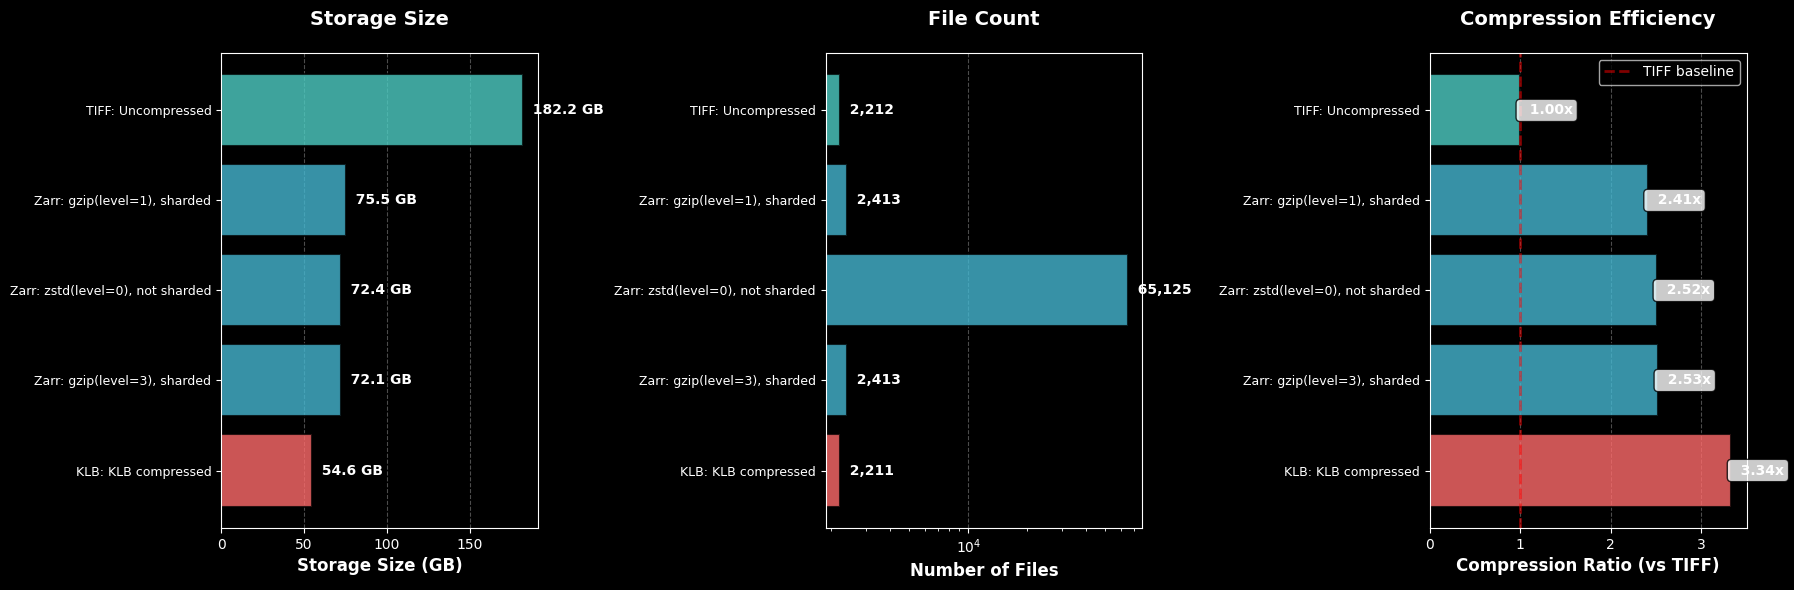


Comparison complete!


In [92]:
# Merge metadata inspection with file size data for clean comparison
import matplotlib.pyplot as plt

BASE_PATH = Path(r"\\rbo-s1\S1_DATA\isoview\foconnell\io_corrected_test")

# Get file sizes
def get_dir_size_and_count(directory: Path) -> tuple[float, int]:
    """Return size in GB and file count."""
    if not directory.exists():
        return 0.0, 0
    total_size = 0
    file_count = 0
    for item in directory.rglob('*'):
        if item.is_file():
            total_size += item.stat().st_size
            file_count += 1
    return total_size / (1024**3), file_count

# Build comparison data
comparison_data = []

# Add KLB
klb_dir = BASE_PATH / "klb"
if klb_dir.exists():
    size_gb, file_count = get_dir_size_and_count(klb_dir)
    comparison_data.append({
        'Format': 'KLB',
        'Config': 'KLB compressed',
        'Size (GB)': size_gb,
        'Files': file_count
    })

# Add TIFF
tiff_dir = BASE_PATH / "tiff"
if tiff_dir.exists():
    size_gb, file_count = get_dir_size_and_count(tiff_dir)
    comparison_data.append({
        'Format': 'TIFF',
        'Config': 'Uncompressed',
        'Size (GB)': size_gb,
        'Files': file_count
    })

# Add unique Zarr configurations from metadata inspection
if results_list:
    # Group by actual configuration
    config_to_dirs = {}
    for result in results_list:
        config = result['Actual Configuration']
        if config not in config_to_dirs:
            config_to_dirs[config] = []
        config_to_dirs[config].append(result['Directory Name'])

    # For each unique configuration, use first directory (skip consolidated)
    for config, dir_names in config_to_dirs.items():
        # Use first NON-consolidated directory
        dir_name = None
        for d in dir_names:
            if 'consolidated' not in d.lower():
                dir_name = d
                break

        if dir_name:
            zarr_dir = BASE_PATH / dir_name
            if zarr_dir.exists():
                size_gb, file_count = get_dir_size_and_count(zarr_dir)
                comparison_data.append({
                    'Format': 'Zarr',
                    'Config': config,
                    'Size (GB)': size_gb,
                    'Files': file_count
                })

# Create DataFrame
df_clean = pd.DataFrame(comparison_data)

# Calculate compression ratio
tiff_size = df_clean[df_clean['Format'] == 'TIFF']['Size (GB)'].iloc[0] if len(df_clean[df_clean['Format'] == 'TIFF']) > 0 else 1
df_clean['Compression Ratio'] = tiff_size / df_clean['Size (GB)']

# Sort by size
df_clean = df_clean.sort_values('Size (GB)')

print("CLEAN COMPARISON (Unique Configurations)")
print("=" * 80)
print(df_clean[['Format', 'Config', 'Size (GB)', 'Files', 'Compression Ratio']].to_string(index=False))

# Save to CSV
output_csv = BASE_PATH / "clean_format_comparison.csv"
df_clean.to_csv(output_csv, index=False)
print(f"\nSaved to: {output_csv}")

# Create concise visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Colors
colors_map = {'KLB': '#FF6B6B', 'TIFF': '#4ECDC4', 'Zarr': '#45B7D1'}
colors = [colors_map.get(fmt, '#95A5A6') for fmt in df_clean['Format']]

# Plot 1: Storage Size
ax1 = axes[0]
bars1 = ax1.barh(range(len(df_clean)), df_clean['Size (GB)'], color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)
ax1.set_yticks(range(len(df_clean)))
ax1.set_yticklabels([f"{row['Format']}: {row['Config']}" for _, row in df_clean.iterrows()], fontsize=9)
ax1.set_xlabel('Storage Size (GB)', fontsize=12, fontweight='bold')
ax1.set_title('Storage Size', fontsize=14, fontweight='bold', pad=20)
ax1.grid(axis='x', alpha=0.3, linestyle='--')
ax1.set_axisbelow(True)

for i, (bar, size) in enumerate(zip(bars1, df_clean['Size (GB)'])):
    ax1.text(size, bar.get_y() + bar.get_height()/2, f'  {size:.1f} GB',
            ha='left', va='center', fontsize=10, fontweight='bold')

# Plot 2: File Count
ax2 = axes[1]
bars2 = ax2.barh(range(len(df_clean)), df_clean['Files'], color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)
ax2.set_yticks(range(len(df_clean)))
ax2.set_yticklabels([f"{row['Format']}: {row['Config']}" for _, row in df_clean.iterrows()], fontsize=9)
ax2.set_xlabel('Number of Files', fontsize=12, fontweight='bold')
ax2.set_title('File Count', fontsize=14, fontweight='bold', pad=20)
ax2.grid(axis='x', alpha=0.3, linestyle='--')
ax2.set_axisbelow(True)
ax2.set_xscale('log')

for i, (bar, count) in enumerate(zip(bars2, df_clean['Files'])):
    ax2.text(count, bar.get_y() + bar.get_height()/2, f'  {count:,}',
            ha='left', va='center', fontsize=10, fontweight='bold')

# Plot 3: Compression Ratio
ax3 = axes[2]
bars3 = ax3.barh(range(len(df_clean)), df_clean['Compression Ratio'], color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)
ax3.set_yticks(range(len(df_clean)))
ax3.set_yticklabels([f"{row['Format']}: {row['Config']}" for _, row in df_clean.iterrows()], fontsize=9)
ax3.set_xlabel('Compression Ratio (vs TIFF)', fontsize=12, fontweight='bold')
ax3.set_title('Compression Efficiency', fontsize=14, fontweight='bold', pad=20)
ax3.axvline(x=1.0, color='red', linestyle='--', linewidth=2, alpha=0.5, label='TIFF baseline')
ax3.grid(axis='x', alpha=0.3, linestyle='--')
ax3.set_axisbelow(True)
ax3.legend()

for i, (bar, ratio) in enumerate(zip(bars3, df_clean['Compression Ratio'])):
    ax3.text(ratio, bar.get_y() + bar.get_height()/2, f'  {ratio:.2f}x',
            ha='left', va='center', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='black'))

plt.tight_layout()

# Save figure
output_fig = BASE_PATH / "clean_format_comparison.png"
plt.savefig(output_fig, dpi=300, bbox_inches='tight')
print(f"\nFigure saved to: {output_fig}")

plt.show()